In [1]:
import pandas
import matplotlib
import seaborn
import collections
import itertools

import sys
sys.path.append('..')

from helpers import (ECOSYSTEMS, DATE_RANGE, load_data, create_snapshot, load_graph, 
                     RE_SEMVER, compare_distributions, savefig)

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('Set1', n_colors=len(ECOSYSTEMS))
seaborn.set_style('whitegrid')

In [47]:
FIG_SIZE = (8, 4)
FIG_SIZE_WIDE = (10, 4)
FIG_DATE_RANGE = (DATE_RANGE[0], DATE_RANGE[-1])  #(pandas.to_datetime('2007-01-01'), DATE_RANGE[-1])
COLORS = {ecosystem: seaborn.color_palette()[i] for i, ecosystem in enumerate(ECOSYSTEMS)}

In [3]:
df_data = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=', ')
    packages, dependencies = load_data(ecosystem)
    df_data[ecosystem] = {
        'packages': packages, 
        'dependencies': dependencies,
    }

cargo, cpan, cran, npm, nuget, packagist, rubygems, 

## Characteristics

In [4]:
df = pandas.DataFrame(index=ECOSYSTEMS)

for ecosystem, data in df_data.items():
    # Number of packages, versions and dependencies
    df.loc[ecosystem, 'packages'] = len(data['packages'].groupby('package'))
    df.loc[ecosystem, 'releases'] = len(data['packages'])
    df.loc[ecosystem, 'dependencies'] = len(data['dependencies'])
    
    # Oldest package
    df.loc[ecosystem, 'from_date'] = data['packages']['time'].min()
    df.loc[ecosystem, 'to_date'] = data['packages']['time'].max()
    
    # Latest snapshot
    sn_packages, sn_dependencies = create_snapshot(data['packages'], data['dependencies'], df.loc[ecosystem, 'to_date'])
    df.loc[ecosystem, 'sn_dependencies'] = len(sn_dependencies)
    
df.T

,cargo,cpan,cran,npm,nuget,packagist,rubygems
packages,8726,34105,9568,462155,84308,97149,132118
releases,48482,258987,57530,3.03762e+06,935651,668905,795224
dependencies,150251,1.07812e+06,128113,1.36945e+07,1.66539e+06,1.8633e+06,1.89357e+06
from_date,2014-11-11 00:22:07,1995-08-19 22:00:00,1997-10-08 19:56:17,2010-11-09 23:36:08,2011-01-07 07:49:38,1994-08-23 00:00:00,1999-12-31 13:30:00
to_date,2017-04-05 11:51:32,2017-04-05 11:19:02,2016-04-26 20:52:26,2017-04-05 00:38:39,2017-04-05 10:17:32,2017-04-05 08:43:17,2017-04-04 17:26:30
sn_dependencies,21840,105429,22191,1.25575e+06,129678,176230,190424


In [5]:
df.sum()

packages             828129.0
releases            5802397.0
dependencies       20473210.0
sn_dependencies     1901541.0
dtype: float64

## Packages, releases and dependencies over time

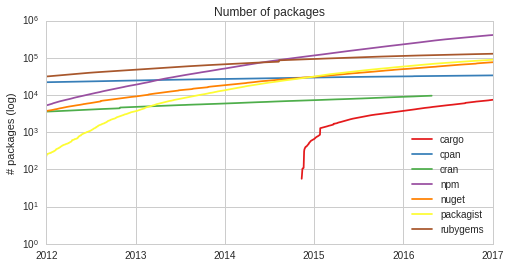

In [6]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby('package')
        [['time']]
        .min()
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of packages',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_number_of_packages')

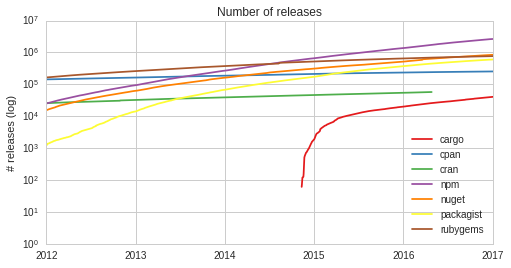

In [7]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='Number of releases',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_number_of_releases')

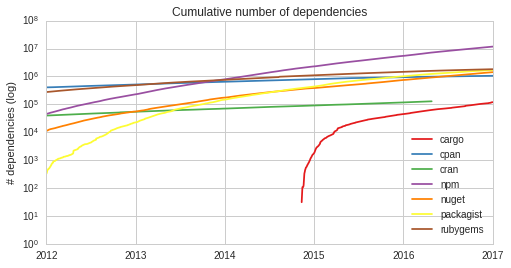

In [8]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .merge(data['dependencies'], how='right', on=['package', 'version'])
        [['time']]
        .assign(time=lambda d: d['time'].dt.date)  # Date conversion for mpl
        .assign(**{ecosystem: 1})
        .groupby('time')
        .sum()
        .sort_index()
        .cumsum()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])

ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Cumulative number of dependencies',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_cumulative_number_of_dependencies')

## New packages and releases  by month

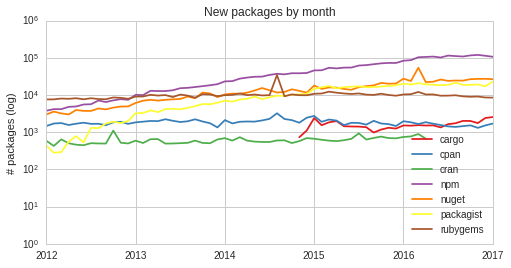

In [9]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        .groupby(['package', 'version'])
        [['time']]
        .min()
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='New packages by month',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_new_packages_by_month')

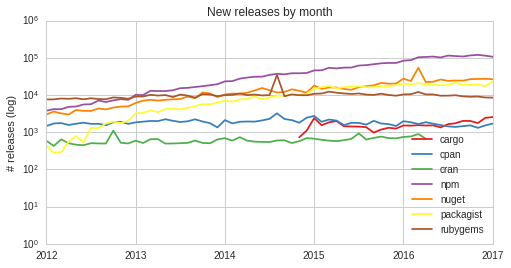

In [10]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    # Packages
    df = (data['packages']
        [['time']]
        .assign(**{ecosystem: 1})
        .set_index('time')
        .resample('1M')
        .count()
    )
    
    df.plot(ax=ax, logy=True, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='# releases (log)',
    title='New releases by month',
    xlim=FIG_DATE_RANGE,
)

savefig(figure, 'act_new_releases_by_month')

## Delay before first update

In [11]:
# Time of first and next release
for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .sort_values(['package', 'time'])
        .set_index(['package', 'version'])
        .assign(next_release=lambda d: d['time'].shift(-1))
    )
    index_of_last_releases = (
        df
        .groupby(level='package', sort=False)
        .tail(1)
        .index
    )
    df.loc[index_of_last_releases, 'next_release'] = pandas.NaT
    df = df.reset_index()
    
    df_data[ecosystem]['packages'] = (
        df
        .groupby('package')
         [['time']]
         .min()
         .assign(first_release=lambda d: d['time'])
         [['first_release']]
         .reset_index()
         .merge(df, how='left', on='package')
    )

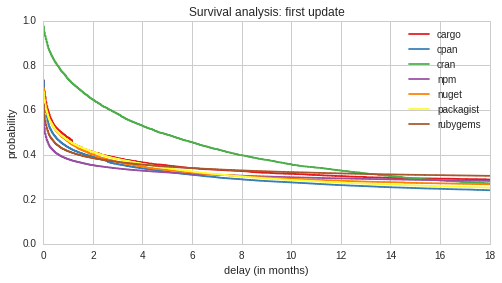

In [12]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():    
    kmp_df = (
        data['packages']
        [data['packages']['time'] == data['packages']['first_release']]
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['first_release'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: first update',
    xlim=(0, 18),
    ylim=(0, 1)
)    


savefig(figure, 'act_survival_first_update')

## Delay between successive releases

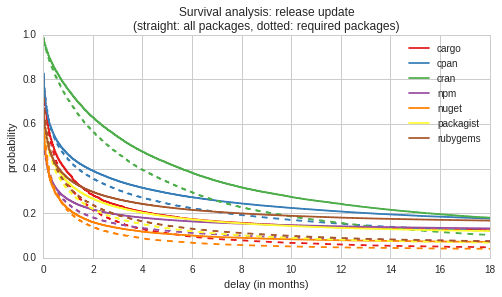

In [14]:
import lifelines
from lifelines.statistics import logrank_test

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for ecosystem, data in df_data.items():
    kmp_df = (
        data['packages']
        .assign(observed=lambda d: ~d['next_release'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_release'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
        .assign(required=lambda d: d['package'].isin(data['dependencies']['dependency']))
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
    required = kmp_df['required'] == True
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'])
    kmp.plot(ax=ax, color=COLORS[ecosystem], style='--', legend=None, ci_show=False)
    
    tests[ecosystem] = logrank_test(
        kmp_df['duration'], kmp_df[required]['duration'],
        kmp_df['observed'], kmp_df[required]['observed'],
        alpha=0.99
    )
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: release update\n(straight: all packages, dotted: required packages)',
    xlim=(0, 18),
    ylim=(0, 1)
)    


savefig(figure, 'act_survival_update_release')

In [15]:
for ecosystem, test in tests.items():
    print('{}: {}, significant: {}'.format(ecosystem, test.test_result, test.is_significant))

cargo: Reject Null, significant: True
cpan: Reject Null, significant: True
cran: Reject Null, significant: True
npm: Reject Null, significant: True
nuget: Reject Null, significant: True
packagist: Reject Null, significant: True
rubygems: Reject Null, significant: True


## Correlation between updates and dependencies

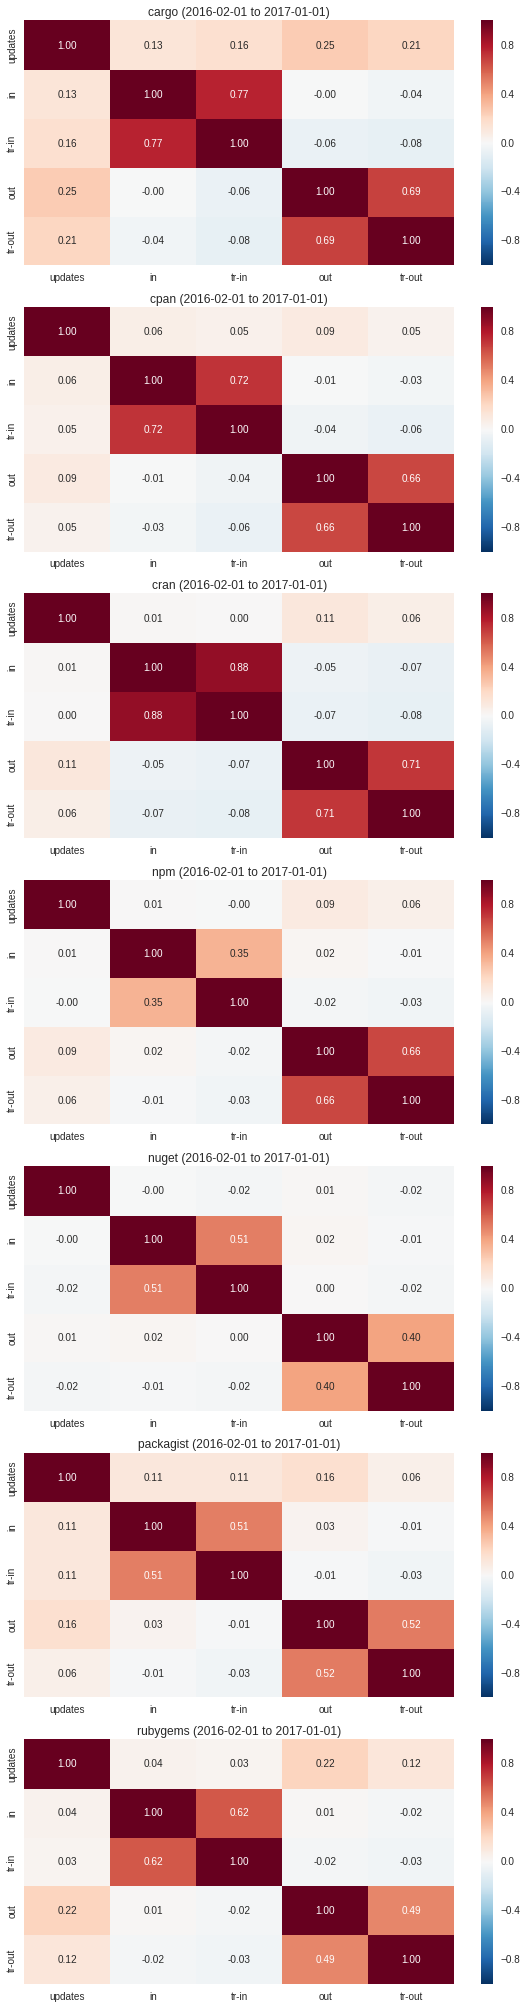

In [16]:
figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1]*len(ECOSYSTEMS)))

INTERVAL = [DATE_RANGE[-12], DATE_RANGE[-1]]

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    graph = load_graph(ecosystem, INTERVAL[0])
    mask = (INTERVAL[0] <= data['packages']['time']) & (data['packages']['time'] < INTERVAL[1])

    updates = (
        data['packages'][mask]
        [['package', 'version']]
        .groupby('package')
        .count()
        .reset_index()
        .rename(columns={'version': 'updates'})
    )

    for metric in ['in', 'tr-in', 'out', 'tr-out']:
        metric_df = pandas.DataFrame.from_records(
            zip(graph.vs['name'], graph.vs[metric]), 
            columns=['package', metric]
        )
        updates = updates.merge(metric_df, on='package')

    updates = updates.set_index('package').fillna(0)
    
    seaborn.heatmap(updates.corr(), annot=True, fmt='2.2f', ax=ax)
    ax.set(
        title='{} ({} to {})'.format(
            ecosystem, 
            INTERVAL[0].strftime('%Y-%m-%d'),
            INTERVAL[1].strftime('%Y-%m-%d')
        ),
    )
    
matplotlib.pyplot.tight_layout()    


savefig(figure, 'act_correlation_update_degree')

## Packages with semver

In [17]:
# Extract semver
for ecosystem, data in df_data.items():
    data['packages'] = (
        pandas.concat([
            data['packages'], 
            data['packages']['version'].str.extract(RE_SEMVER, expand=True)
        ], axis=1, join='inner')
        .assign(semver=lambda d: ~(d[['v_major', 'v_minor', 'v_patch']].isnull().any(axis=1)))
        # Convert to int
        .assign(
            v_major=lambda d: pandas.to_numeric(d['v_major'], errors='ignore'),
            v_minor=lambda d: pandas.to_numeric(d['v_minor'], errors='ignore'),
            v_patch=lambda d: pandas.to_numeric(d['v_patch'], errors='ignore'),
        )
    )

In [18]:
# Tag package "semver_all" if all its releases are semver compliant
for ecosystem, data in df_data.items():
    not_semver = (
        data['packages']
        .query('semver == False')
        ['package']
    )
    data['packages'] = (
        data['packages']
        .assign(semver_all=lambda d: ~d['package'].isin(not_semver))
    )

In [19]:
# Detect release type
for ecosystem, data in df_data.items():

    df = (
        data['packages']
        # Keep packages that are fully semver compliant
        .query('semver_all == True')
        .sort_values(['package', 'v_major', 'v_minor', 'v_patch', 'time'])

        # Shift to combine previous/current version
        .pipe(lambda d: 
            d.join(
                d[['package', 'v_major', 'v_minor', 'v_patch', 'time']].shift(1),
                rsuffix='_previous'
            )
        )
        # Shift to combine next version
        .pipe(lambda d: 
            d.join(
                d[['package', 'time']].shift(-1),
                rsuffix='_next'
            )
        )
        .assign(release_type='patch')
        .assign(release_delay=lambda d: d['time'] - d['time_previous'])
        .assign(next_release_delay=lambda d: d['time_next'] - d['time'])
    )

    #df.loc[df['v_patch'] != df['v_patch_previous'], 'release_type'] = 'patch'
    df.loc[df['v_minor'] != df['v_minor_previous'], 'release_type'] = 'minor'
    df.loc[df['v_major'] != df['v_major_previous'], 'release_type'] = 'major'
    df.loc[df['package'] != df['package_previous'], 'release_type'] = 'initial'
    df.loc[df['package'] != df['package_previous'], 'release_delay'] = pandas.NaT
    df.loc[df['package'] != df['package_next'], 'next_release_delay'] = pandas.NaT

    data['semver'] = df.drop(
        ['semver', 'semver_all', 'package_previous', 'v_patch_previous', 'v_minor_previous', 
         'v_major_previous', 'time_previous', 'package_next', 'time_next'],
        axis=1
    )

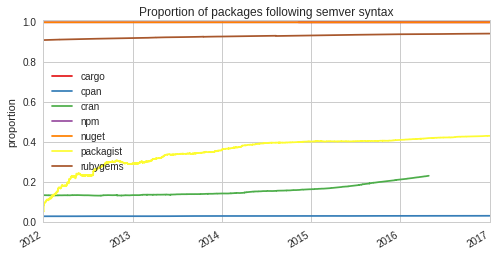

In [20]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

for ecosystem, data in df_data.items():
    df = (
        data['packages']
        .groupby('package')
        [['time', 'semver_all']]
        .min()
        .set_index('time')
        .sort_index()
        .assign(n=1, n_semver=lambda d: d['semver_all'].astype(int))
        [['n', 'n_semver']]
        .cumsum()
        .assign(**{ecosystem: lambda d: d['n_semver'] / d['n']})
    )
    
    df[[ecosystem]].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Proportion of packages following semver syntax',
    xlim=FIG_DATE_RANGE,
    ylim=(0, 1.01),
)


savefig(figure, 'act_packages_with_semver')

## Packages that adopted semver

In [21]:
# TODO

## Type of releases for packages with semver

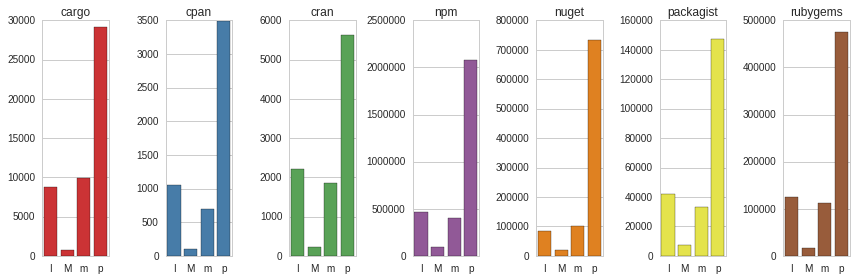

In [45]:
figure, axes = matplotlib.pyplot.subplots(ncols=len(ECOSYSTEMS))
figure.set_size_inches(FIG_SIZE_WIDE)

# figure.suptitle('Type of release for packages following semver')

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    seaborn.countplot(
        x='release_type', 
        data=data['semver'],# .query('release_type != "initial"'),
        order=['initial', 'major', 'minor', 'patch'],
        color=COLORS[ecosystem],
        ax=ax
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='',
        # yscale='log',
    )
    ax.set_xticklabels(['I', 'M', 'm', 'p'])

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_type_of_releases')

## Distribution of release types per package

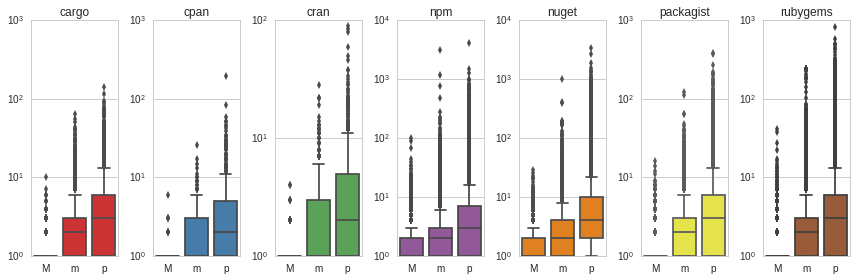

In [46]:
figure, axes = matplotlib.pyplot.subplots(ncols=len(ECOSYSTEMS))
figure.set_size_inches(FIG_SIZE_WIDE)

# figure.suptitle('Type of release for packages following semver')

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
    seaborn.boxplot(
        x='release_type', 
        y='version',
        data=data['semver'].groupby(['package', 'release_type']).count().reset_index(),
        order=['major', 'minor', 'patch'],
        color=COLORS[ecosystem],
        ax=ax
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='',
        yscale='log',
    )
    ax.set_xticklabels(['M', 'm', 'p'])

matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_types_distribution')

## Number of patch releases per minor release, minor releases per major release and majors releases per package

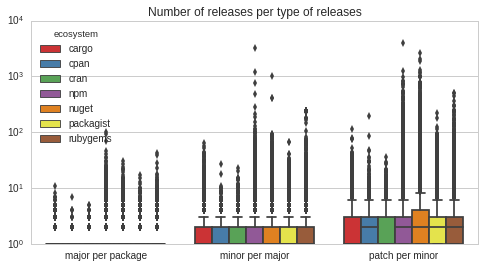

In [24]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

data_temp = []
for ecosystem, data in df_data.items():
    patches = (
        data['semver']
        [['package', 'v_major', 'v_minor', 'v_patch']]
        .groupby(['package', 'v_major', 'v_minor'])
        .count()
        ['v_patch']
    )

    minors = (
        data['semver']
        [['package', 'v_major', 'v_minor']]
        .drop_duplicates()
        .groupby(['package', 'v_major'])
        .count()
        ['v_minor']
    )
    
    majors = (
        data['semver']
        [['package', 'v_major']]
        .drop_duplicates()
        .groupby('package')
        .count()
        ['v_major']
    )
    
    for label, nbs in [('patch per minor', patches), ('minor per major', minors), ('major per package', majors)]:
        for nb in nbs:
            data_temp.append((ecosystem, label, nb))

data_temp = pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'type', 'n'])   
            
seaborn.boxplot(
    x='type',
    y='n', 
    hue='ecosystem',
    data = data_temp,
    order=['major per package', 'minor per major', 'patch per minor'], 
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Number of releases per type of releases',
    xlabel='', 
    ylabel='',
    yscale='log',
)

savefig(figure, 'act_semver_types_distribution_per_types')

In [25]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    for a, b in [('major per package', 'minor per major'), ('minor per major', 'patch per minor')]:
        df = data_temp.query('ecosystem == "{}"'.format(ecosystem))
        a_v = df[df['type'] == a]['n'].values
        b_v = df[df['type'] == b]['n'].values
    
        score, p_value, d, label = compare_distributions(a_v, b_v)
        print('{} < {} : {} (p-value: {}), Cliff\'s delta: {} ({})'.format(a, b, score, p_value, d, label))
    print()

cargo
major per package < minor per major : 28533469.5 (p-value: 0.0), Cliff's delta: 0.3051557771621834 (small)
minor per major < patch per minor : 81156197.5 (p-value: 1.135058451051003e-63), Cliff's delta: 0.10927840311817213 (negligible)

cpan
major per package < minor per major : 479359.0 (p-value: 7.10633441002367e-37), Cliff's delta: 0.2083554216767984 (small)
minor per major < patch per minor : 758373.0 (p-value: 7.232104935718192e-49), Cliff's delta: 0.286455437160398 (small)

cran
major per package < minor per major : 1948269.0 (p-value: 3.695755815467568e-111), Cliff's delta: 0.27772871855328424 (small)
minor per major < patch per minor : 4446487.0 (p-value: 2.1239650392309097e-30), Cliff's delta: 0.1502304790371098 (small)

npm
major per package < minor per major : 107758056446.5 (p-value: 0.0), Cliff's delta: 0.16195920109328238 (small)
minor per major < patch per minor : 193939180632.5 (p-value: 0.0), Cliff's delta: 0.27467057679699464 (small)

nuget
major per package < m

## Highest major component value per package

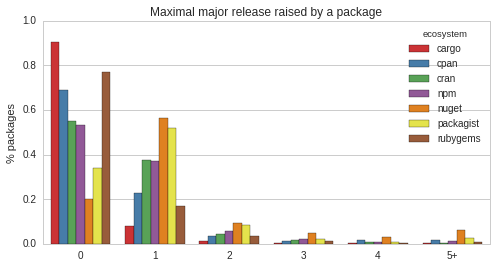

In [26]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5+']

data_temp = []
for ecosystem, data in df_data.items():
    
    df = (data['semver']
          [['package', 'v_major']]
          .drop_duplicates(['package', 'v_major'])
          .sort_values('v_major')
          .drop_duplicates(['package'], keep='last')
          ['v_major']
          .astype(int)
    )
    
    counter = collections.Counter(
            pandas.cut(
                df,
                bins=bins,
                labels=labels,
                right=False,
                include_lowest=True,
            )
        )
    
    nb_packages = len(data['semver'].drop_duplicates(['package']))
    for label in labels: 
        data_temp.append((ecosystem, label, counter[label] / nb_packages))

seaborn.barplot(
    data=pandas.DataFrame.from_records(data_temp, columns=['ecosystem', 'value', 'p']),
    x='value', 
    y='p', 
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Maximal major release raised by a package',
    xlabel='',
    ylabel='% packages',
    ylim=(0, 1),
)

savefig(figure, 'act_semver_highest_major')

## Number of releases per major component, per package

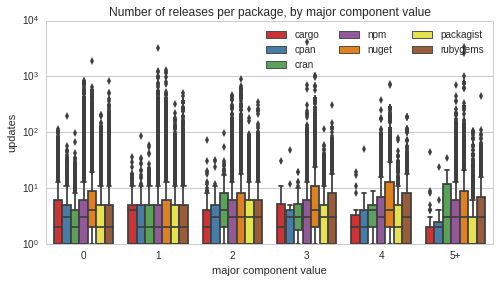

In [38]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE_WIDE)

bins = [0, 1, 2, 3, 4, 5, pandas.np.inf]
labels = ['0', '1', '2', '3', '4', '5+']

df = pandas.concat(
    [
        df_data[ecosystem]['semver']
            [['package', 'v_major', 'version']]
            .groupby(['package', 'v_major'])
            .count()
            [['version']]
            .reset_index()
            .assign(v_major=lambda d: pandas.cut(
                  d['v_major'].astype(int),
                  bins=bins,
                  labels=labels,
                  right=False,
                  include_lowest=True)
            )
            .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ]
)

seaborn.boxplot(
    data=df,
    x='v_major',
    y='version',
    hue='ecosystem',
    order=labels,
    hue_order=ECOSYSTEMS,
    palette=COLORS,
    ax=ax
)

ax.set(
    title='Number of releases per package, by major component value',
    xlabel='major component value',
    ylabel='updates',
    yscale='log',
)
ax.legend(ncol=len(ECOSYSTEMS) // 2)

savefig(figure, 'act_semver_releases_by_major')

## Delay for a release, by release type

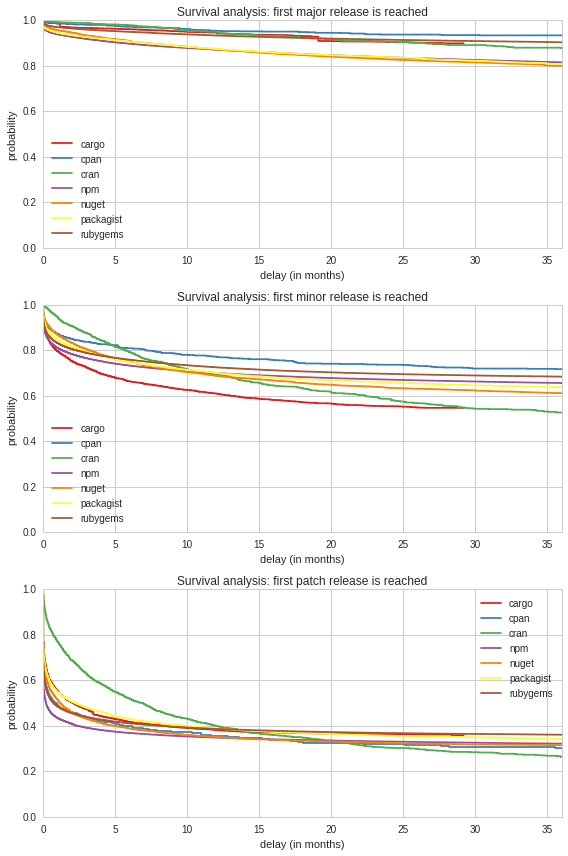

In [28]:
# Time to reach a first release of given type

import lifelines

figure, axes = matplotlib.pyplot.subplots(nrows=3)
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * 3))

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    kmp_df = (
        data['semver']
        .groupby(['package', 'release_type'])
        [['time']]
        .min()
        .reset_index(level=1)
        .assign(time=lambda d: d['time'])
        .pivot(columns='release_type', values='time')
        .assign(
            major_observed=lambda d: ~d['major'].isnull(),
            minor_observed=lambda d: ~d['minor'].isnull(),
            patch_observed=lambda d: ~d['patch'].isnull(),
        )
        .fillna(data['semver']['time'].max())
        .assign(
            major_delay=lambda d: (d['major'].astype('datetime64[ns, UTC]') - d['initial'].astype('datetime64[ns, UTC]')).dt.days / 30,
            minor_delay=lambda d: (d['minor'].astype('datetime64[ns, UTC]') - d['initial'].astype('datetime64[ns, UTC]')).dt.days / 30,
            patch_delay=lambda d: (d['patch'].astype('datetime64[ns, UTC]') - d['initial'].astype('datetime64[ns, UTC]')).dt.days / 30,
        )
    )

    for i, kind in enumerate(['major', 'minor', 'patch']):
        ax = axes[i]
        
        kmp.fit(kmp_df['%s_delay' % kind], kmp_df['%s_observed' % kind], label=ecosystem)
        kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)

        ax.set(
            xlabel='delay (in months)',
            ylabel='probability', 
            title='Survival analysis: first {} release is reached'.format(kind),
            xlim=(0, 36),
            ylim=(0, 1)
        )
        # ax.set_ylim(top=1)
    
matplotlib.pyplot.tight_layout()    

savefig(figure, 'act_semver_survival_first_release')

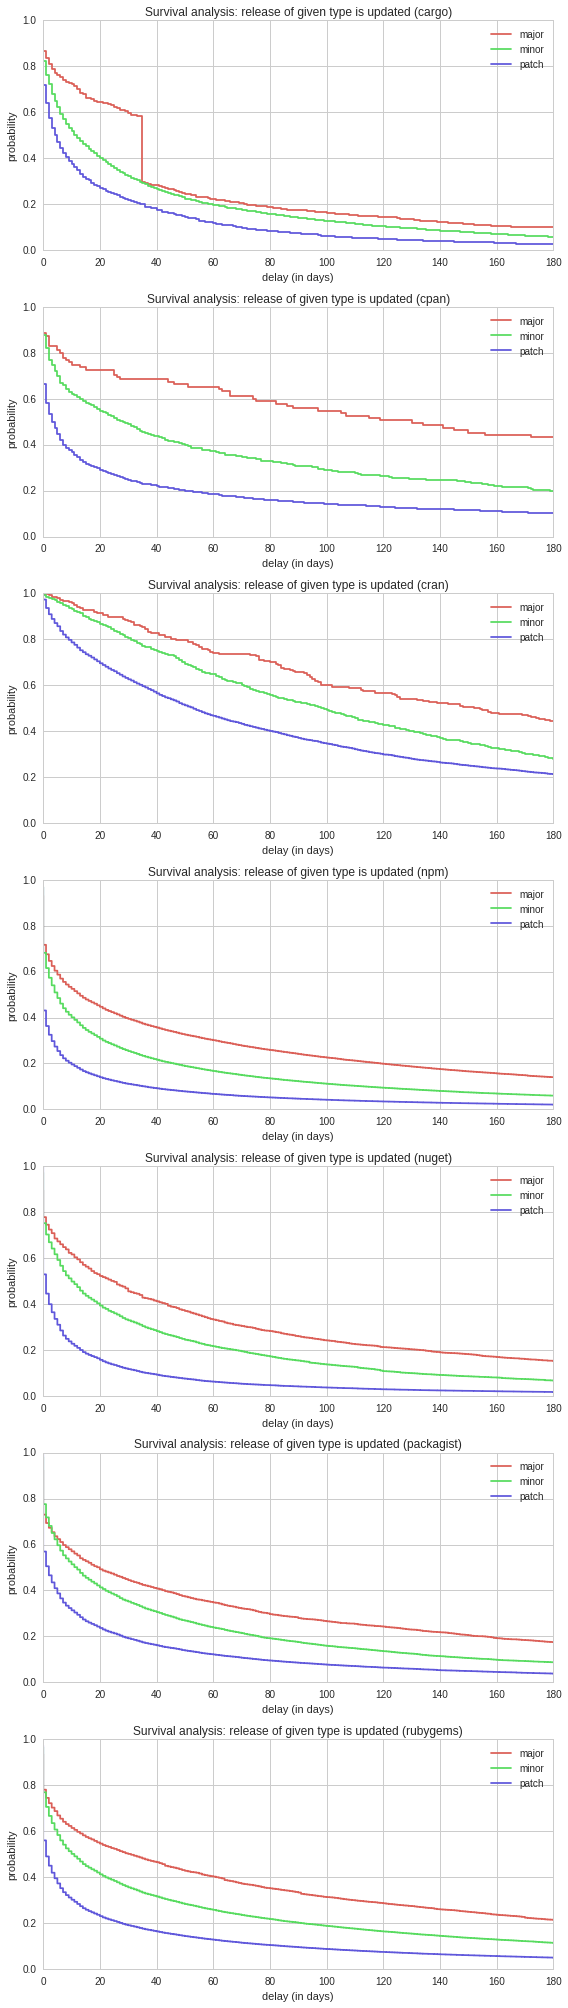

In [29]:
# Delay for an update of a given type, regardless of the type of the previous update

import lifelines
from lifelines.statistics import logrank_test

figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))

colors = iter(itertools.cycle(seaborn.color_palette('hls', 3)))

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
                    
    kmp_df = collections.OrderedDict()
    for update_kind in ['major', 'minor', 'patch']:
        color = next(colors)
        
        kmp_df[update_kind] = (
            data['semver']
            .query('release_type == "{}"'.format(update_kind))
            .assign(duration=lambda d: d['release_delay'].dt.days)
        )

        kmp.fit(kmp_df[update_kind]['duration'], label=update_kind)
        kmp.plot(ax=ax, color=color, ci_show=False)

    tests[ecosystem] = [
        ('major vs minor', logrank_test(kmp_df['major']['duration'], kmp_df['minor']['duration'], alpha=0.99)),
        ('minor vs patch', logrank_test(kmp_df['minor']['duration'], kmp_df['patch']['duration'], alpha=0.99)),
    ]
        
    ax.set(
        xlabel='delay (in days)',
        ylabel='probability', 
        title='Survival analysis: release of given type is updated ({})'.format(ecosystem),
        xlim=(0, 180),
        ylim=(0, 1)
    )    
    
matplotlib.pyplot.tight_layout()    

savefig(figure, 'act_semver_survival_type_is_updated')

In [30]:
for ecosystem, results in tests.items():
    print(ecosystem)
    for label, test in results: 
        print('{}: {}, significant: {}'.format(label, test.test_result, test.is_significant))

cargo
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
cpan
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
cran
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
npm
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
nuget
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
packagist
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
rubygems
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True


In [31]:
# Delay for an update of a given type, wrt. to a previous update of the same type

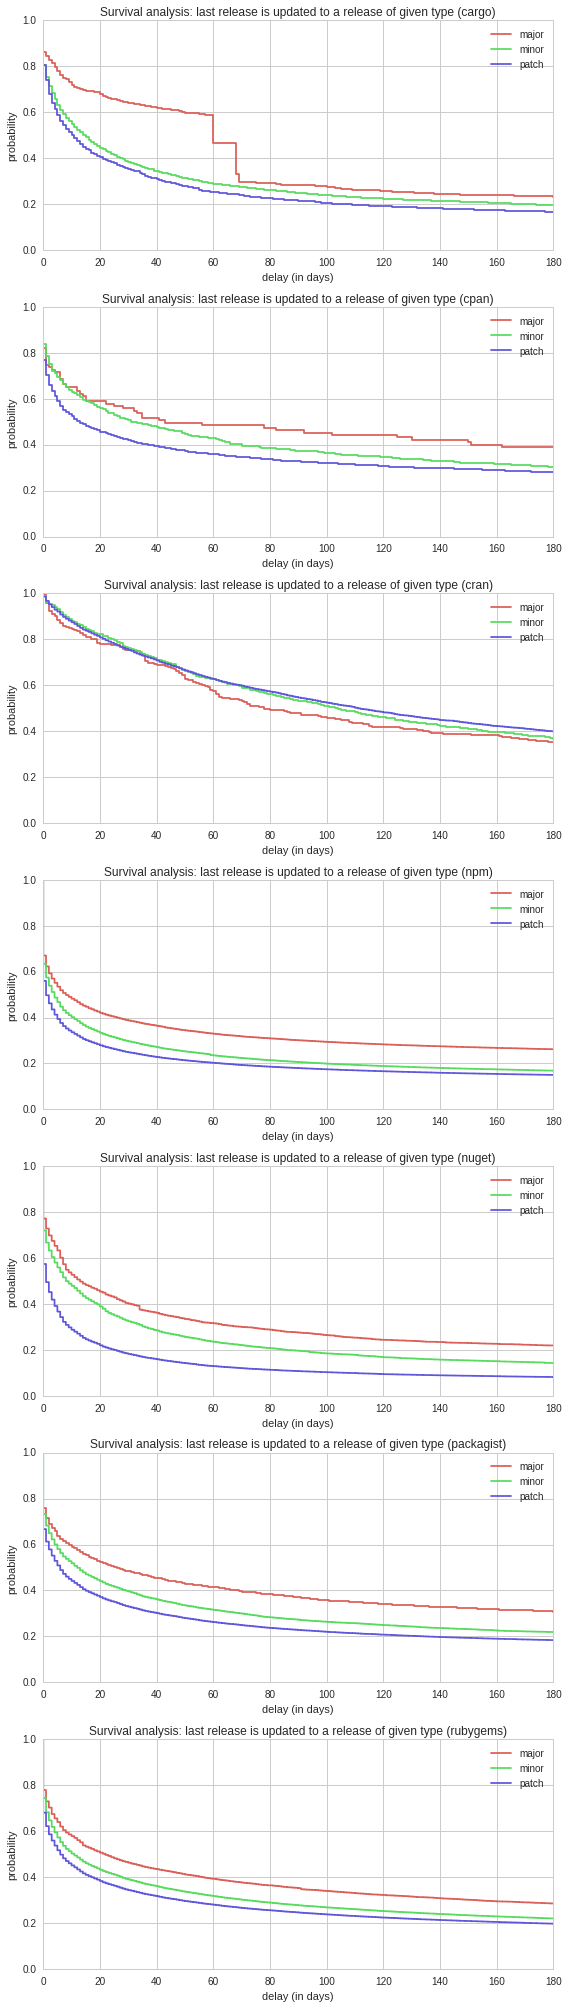

In [32]:
# Delay for an update (no matter its type) wrt. to a previous update of given type

import lifelines
from lifelines.statistics import logrank_test

figure, axes = matplotlib.pyplot.subplots(nrows=len(ECOSYSTEMS))
figure.set_size_inches((FIG_SIZE[0], FIG_SIZE[1] * len(ECOSYSTEMS)))

colors = iter(itertools.cycle(seaborn.color_palette('hls', 3)))

kmp = lifelines.KaplanMeierFitter()
tests = collections.OrderedDict()

for i, (ecosystem, data) in enumerate(df_data.items()):
    ax = axes[i]
                    
    kmp_df = collections.OrderedDict()
    for update_kind in ['major', 'minor', 'patch']:
        color = next(colors)
        
        kmp_df[update_kind] = (
            data['semver']
            .query('release_type == "{}"'.format(update_kind))
            .assign(duration=lambda d: d['next_release_delay'].dt.days)
        )

        kmp.fit(kmp_df[update_kind]['duration'], label=update_kind)
        kmp.plot(ax=ax, color=color, ci_show=False)

    tests[ecosystem] = [
        ('major vs minor', logrank_test(kmp_df['major']['duration'], kmp_df['minor']['duration'], alpha=0.99)),
        ('minor vs patch', logrank_test(kmp_df['minor']['duration'], kmp_df['patch']['duration'], alpha=0.99)),
    ]
    
    ax.set(
        xlabel='delay (in days)',
        ylabel='probability', 
        title='Survival analysis: last release is updated to a release of given type ({})'.format(ecosystem),
        xlim=(0, 180),
        ylim=(0, 1)
    )    
    
matplotlib.pyplot.tight_layout()

savefig(figure, 'act_semver_survival_updated_to_type')

In [33]:
for ecosystem, results in tests.items():
    print(ecosystem)
    for label, test in results: 
        print('{}: {}, significant: {}'.format(label, test.test_result, test.is_significant))

cargo
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
cpan
major vs minor: Cannot Reject Null, significant: False
minor vs patch: Reject Null, significant: True
cran
major vs minor: Cannot Reject Null, significant: False
minor vs patch: Cannot Reject Null, significant: False
npm
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
nuget
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
packagist
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True
rubygems
major vs minor: Reject Null, significant: True
minor vs patch: Reject Null, significant: True


## Delay and number of updates to reach a major update

In [34]:
# TODO...

## Delay before first dependent

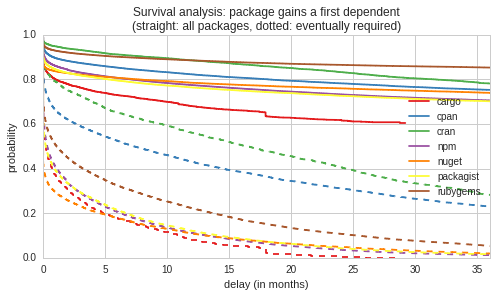

In [35]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    first_dependent = (
        data['packages']
        .merge(data['dependencies'], on=['package', 'version'])
        [['dependency', 'time']]
        .groupby('dependency')
        .min()
        .rename(columns={'time': 'dependent'})
    )

    kmp_df = (
        data['packages']
        .groupby('package')
        [['time']]
        .min()
        .join(first_dependent)
        .assign(observed=lambda d: ~d['dependent'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: (d['dependent'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30)
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
    required = kmp_df['observed'] == True
    kmp.fit(kmp_df[required]['duration'], kmp_df[required]['observed'])
    kmp.plot(ax=ax, color=COLORS[ecosystem], style='--', legend=None, ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: package gains a first dependent\n(straight: all packages, dotted: eventually required)',
    xlim=(0, 36),
    ylim=(0, 1)
)    

savefig(figure, 'act_survival_first_dependent')

## Delay between consecutive dependents

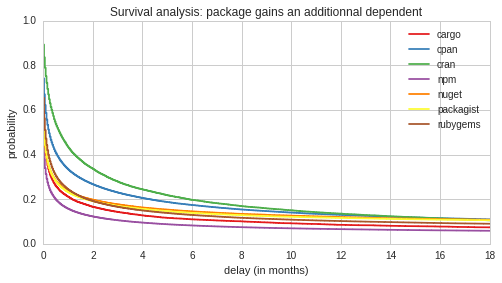

In [36]:
import lifelines

figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

kmp = lifelines.KaplanMeierFitter()

for ecosystem, data in df_data.items():
    df = (data['dependencies']
     .merge(data['packages'], on=['package', 'version'])
     .groupby(['package', 'dependency'])
     [['time']]
     .min()
     .reset_index()
     [['dependency', 'time']]
     .sort_values(['dependency', 'time'])
     .set_index('dependency')
     .assign(next_dependent=lambda d: d['time'].shift(-1))
     .reset_index()
    )

    index_of_last_dependents = (
        df
        .groupby('dependency', sort=False)
        .tail(1)
        .index
    )

    df.loc[index_of_last_dependents, 'next_dependent'] = pandas.NaT
    
    kmp_df = (
        df
        .assign(observed=lambda d: ~d['next_dependent'].isnull())
        .pipe(lambda d: d.fillna(d['time'].max()))
        .assign(duration=lambda d: 
            (d['next_dependent'].astype('datetime64[ns, UTC]') - d['time'].astype('datetime64[ns, UTC]')).dt.days / 30
        )
    )
    
    kmp.fit(kmp_df['duration'], kmp_df['observed'], label=ecosystem)
    kmp.plot(ax=ax, color=COLORS[ecosystem], ci_show=False)
    
ax.set(
    xlabel='delay (in months)',
    ylabel='probability', 
    title='Survival analysis: package gains an additionnal dependent',
    xlim=(0, 18),
    ylim=(0, 1)
)    

savefig(figure, 'act_survival_additionnal_dependent')

## Type of constraints

In [37]:
# TODO

RE_CONSTRAINT = collections.defaultdict(lambda d: r'^(?P<c_op>=|<|>|<=|>=|~|~>|~=|\^)? ?(?P<c_ver>[^=<>~\^,;]+)$')
RE_WILDCARD = collections.defaultdict(lambda d: r'\*|x|X')
RE_SOFT_CONSTRAINT = collections.defaultdict(lambda d: r'http|\^|~|>|<|\*|\.x')
RE_LOWER_CONSTRAINT = collections.defaultdict(lambda d: r'\^|~|>|\.\*|\.x')
RE_UPPER_CONSTRAINT = collections.defaultdict(lambda d: r'\^|~|<|\.\*|\.x')